# Kaggle Titanic competition

[Kaggle](https://www.kaggle.com/?utm_medium=partner&utm_source=dataquest.io&utm_campaign=dataquest+kagglefun) is a site where people create algorithms and compete against machine learning practitioners around the world. Your algorithm wins the competition if it's the most accurate on a particular data set.

[The Titanic competition](https://www.kaggle.com/c/titanic/overview) is one of the competition in Kaggle

In this project, I am going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions I need to focus on.

### Summary of results

In this project, I have created a pipeline of functions for the workflow of developing the best model for the Kaggle Titanic competition. So far I have built 3 models with different algorithms and selected the best features for them. 

As the result, the Random Forest Classifier provides the highest accuracy in K-Fold cross validation, which the score is 0.83. It means its accuracy in predicting the training set is about 83%.

## Reading in data

In [180]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Creating pipeline of functions

In [181]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [182]:
def data_cleaning(df):
    """Clean dataset by using all the above functions
    
    Usage
    -----
    
    train = data_cleaning(train)
    """
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    dummy_cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    df = create_dummies(df, dummy_cols)
    return df

In [183]:
# apply functions to dataset
train = data_cleaning(train)
holdout = data_cleaning(holdout)

## Data Exploration

In [184]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### SibSp and Parch

The descriptions of SibSp and Parch are following:
- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic

As they are describing similar data, number of family member, I am going to explore these two columns and determine if I can combine them into a new feature.

In [185]:
explore = train[['SibSp', 'Parch', 'Survived']]

explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


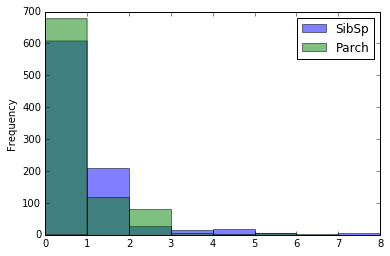

In [186]:
explore[['SibSp', 'Parch']].plot.hist(alpha=0.5,bins=8)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



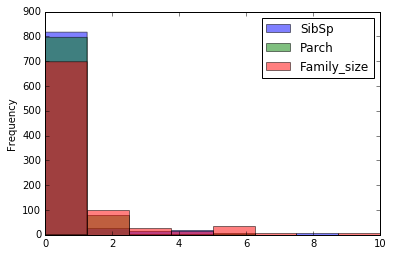

In [187]:
# combine 'SibSp', 'Parch' to 'Family_size'
explore['Family_size'] = explore[['SibSp', 'Parch']].sum(axis=1)

explore[['SibSp', 'Parch', 'Family_size']].plot.hist(alpha=0.5,bins=8)

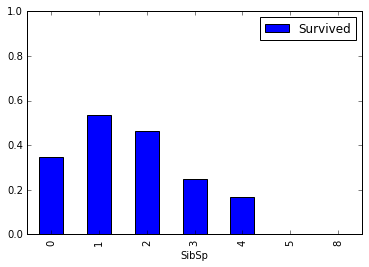

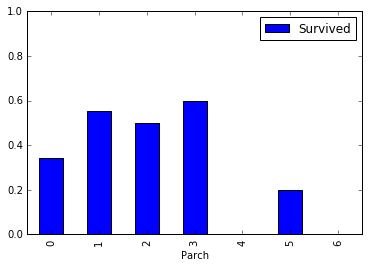

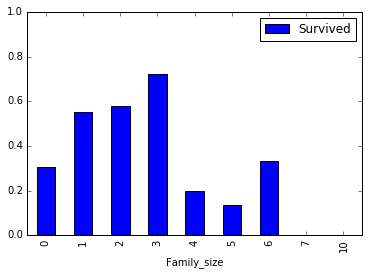

In [188]:
# Distribution of survival rate
for col in ['SibSp', 'Parch', 'Family_size']:
    pivot = explore.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1))
    plt.show

The distribution of values in both 'SibSp' and 'Parch' are skewed right, with the majority of values being zero.

By adding these two columns, we can find the total number of family members each passenger had onboard. The shape of the distribution of values is similar with the distribution of two separated columns. 

The Survial rate charts show that passengers with 1 to 3 family members onboard had the highest survial rate. For the passengers who had no family members onboard, only 30% of them  survived

## Engineering New Features

I will create a new feature to show if the passenger was alone a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [190]:
def process_isalone(df):
    """Create new Columns Family_size and isalone

    Usage
    ------

    train = process_isalone(train)
    """
    df['Family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df.loc[df['Family_size'] == 0, 'isalone'] = 1
    df.loc[df['Family_size'] != 0, 'isalone'] = 0
    df = df.drop('Family_size',axis=1)
    return df

# apply process_isalone to train and holdout
train = process_isalone(train)
holdout = process_isalone(holdout)

## Feature Selection

I will create a function to select the best features for the model. Scikit-learn's feature_selection.RFECV class will be used to automate selecting the best-performing features using recursive feature elimination and Random Forests algorithm will be used to build the model.

In [193]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_feature(df):
    """Select the best features from the dataset columns

    Usage
    ------

    optimized_cols = select_feature(train)
    """
    numercial_cols = df.select_dtypes(include=['integer', 'float'])
    all_X, all_y = numercial_cols.drop(['PassengerId', 'Survived'], axis=1), numercial_cols['Survived']
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc, cv=10)
    selector.fit(all_X, all_y)
    optimized_cols = all_X.columns[selector.support_]
    print('Optimized columns: \n'+'-'*12+'\n{}\n'.format(optimized_cols))
    return optimized_cols

# apply select_feature to train
optimized_cols = select_feature(train)

Optimized columns: 
------------
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



##  Algorithm Selection and Tuning

I will create a function which use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

In [196]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, list_of_features):
    """Select the best model and combinations of hyperparameters

    Usage
    ------

    best_model_dict_with_parameters = select_feature(train, list_of_features)
    """
    all_X, all_y = df[list_of_features], df['Survived']
    models = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
                {
                    'solver': ['newton-cg', 'lbfgs', 'liblinear']
                }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
                {
                    'n_neighbors': range(1,20,2),
                    'weights': ['distance', 'uniform'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1,2]
                }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'hyperparameters':
                {
                    'n_estimators': [4,6,9],
                    'criterion': ['entropy', 'gini'],
                    'max_depth': [2,5,10],
                    'max_features': ['log2', 'sqrt'],
                    'min_samples_leaf': [1,5,8],
                    'min_samples_split': [2,3,5]
                }
        }
    ]
    
    for model in models:
        print(model['name']+': \n'+'-'*12+'\n')
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        model['best_parameters'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_parameters"]))
        
    return models

# apply select_model to train
result = select_model(train,optimized_cols)

LogisticRegression: 
------------

Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier: 
------------

Best Score: 0.7755331088664422
Best Parameters: {'p': 1, 'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute'}

RandomForestClassifier: 
------------

Best Score: 0.8327721661054994
Best Parameters: {'max_depth': 5, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 9, 'min_samples_leaf': 5}



## Conclusion

In this project, I have created a pipeline of functions for the workflow of developing the best model for the Kaggle Titanic competition. So far I have built 3 model with different algorithms and selected the best features for them. 

As the result, The Random Forest Classifier provides the highest accuracy in K-Fold cross validation, which the score is 0.83. It means its accuracy in predicting the training set is about 83%.